# Non-Powered Dams

In [1]:
%load_ext autoreload
%autoreload 2
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import urllib3
urllib3.disable_warnings()
from datetime import date
today = date.today()

# Local imports
from hat.api_call import *
from hat.utils.hydropower_potential import *
from hat.utils.PyGeoTools.geolocation import *

# Read the pre-processed dataset with stream gauges of interest

A spatial analysis was done in order to find the shortest distance between a stream gague and a NPD. However, not all the dams have a stream gauge that can be used in the analysis. This first section filters the pre-processed dataset to get a list of HUC-10 for which there is a stream gauge near a NPD. Some further pre-processing is required:

- The water services REST API for instantaneous values requires a HUC-8. However, the dataset provides a HUC-10. The first 8-digits from the HUC-10 can be used to obtain the HUC-8.
- We do not have the right stream gauge site ID as it is required by the REST API. The column NID is not compatible with the API. Therefore, instead of pulling the data using the HUC codes, we will use the option of a bounding box. We can calculate the bounding box coordinates based on the decimal lat and long provided in the dataset and a default distance of 0.5 km.

In [2]:
input_df = pd.read_csv('../data/combined_npd_stream_gauge.csv')
input_df.head()

,NID ID,lat,lon,dam_name,owner_name,county,city,state,water,max_storage_acft,...,modify_huc_att,huc10,huc4,lat_meter,long_meter,no_huc,graph_dis_stream,stream_gauge_id,graph_dis_dam,shortest_path
0,NH00003,43.468211,-71.661571,FRANKLIN FALLS DAM,CENAE,MERRIMACK,FRANKLIN,NH,PEMIGEWASSET RIVER,222000,...,NM,107000108,107,5354108.405,-7977329.659,No huc 10 or 12,NaN,NaN,NaN,NaN
1,NH00001,43.316118,-71.722383,BLACKWATER DAM,CENAE,MERRIMACK,WEBSTER,NH,BLACKWATER RIVER,93400,...,NM,107000305,107,5330891.619,-7984099.206,No huc 10 or 12,NaN,NaN,NaN,NaN
2,VT00004,43.053504,-72.702723,TOWNSHEND DAM,CENAE,WINDHAM,TOWNSHEND,VT,WEST RIVER,54300,...,NM,108010704,108,5290941.317,-8093230.286,No huc 10 or 12,NaN,NaN,NaN,NaN
3,NY00964,42.917988,-74.446599,LOCK E-13 DAM AT FONDA-FULTONVILLE,NYS CANAL CORP,MONTGOMERY,FONDA FULTONVILLE,NY,ERIE CANAL MOHAWK RIVER,3305,...,TF,202000410,202,5270393.310,-8287357.714,No huc 10 or 12,NaN,NaN,NaN,NaN
4,NY00159,43.676149,-73.779132,STARBUCKVILLE DAM,TOWN OF CHESTER/HORICON/SCHROON,WARREN,SOUTH HORICON,NY,SCHROON RIVER,26688,...,NM,202000106,202,5385945.279,-8213055.587,No huc 10 or 12,NaN,NaN,NaN,NaN


In [3]:
# Replacing the NaNs in the no_huc and shortest_path columns for filtering. A non-NaN value in these columns represent a stream gauge that we could use
empty_data_value = -99999
input_df.no_huc.fillna(1, inplace=True)
input_df.shortest_path.fillna(empty_data_value, inplace=True)

# filtering the gauges of interest
input_df = input_df.loc[(input_df.no_huc == 1) & (input_df.shortest_path != empty_data_value)]
input_df.reset_index(drop=True, inplace=True)

In [4]:
input_df.head()

,NID ID,lat,lon,dam_name,owner_name,county,city,state,water,max_storage_acft,...,modify_huc_att,huc10,huc4,lat_meter,long_meter,no_huc,graph_dis_stream,stream_gauge_id,graph_dis_dam,shortest_path
0,CO01656,40.147715,-105.865879,GRANBY,DOI BR,GRAND,GRANBY,CO,COLORADO RIVER,539760,...,"DM,RS",1401000103,1401,4859876.716,-1.178494e+07,1,0.003,9019500.0,0.021,13.524
1,AR01157,36.466670,-91.530000,MAMMOTH SPRINGS DAM 3,Arkansas Game and Fish Commission,FULTON,NONE,AR,SPRING RIVER,350,...,KA,1101001002,1101,4339629.216,-1.018907e+07,1,0.004,7069220.0,0.017,2.314
2,NM00003,35.394714,-106.547531,JEMEZ CANYON DAM,CESPA,SANDOVAL,BERNALILLO,NM,JEMEZ RIVER,264700,...,NM,1302020205,1302,4192902.854,-1.186082e+07,1,0.009,8328950.0,0.011,0.481
3,PA00110,41.475038,-79.445464,TIONESTA DAM,CELRP,FOREST,TIONESTA,PA,TIONESTA CREEK,180000,...,NM,501000304,501,5054359.215,-8.843829e+06,1,0.010,3020000.0,0.055,1.126
4,AL05901,34.398667,-87.987939,Bear Creek,TVA,Franklin,Red Bay,AL,Bear Creek,37800,...,NM,603000601,603,4058321.364,-9.794773e+06,1,0.020,3592000.0,0.000,53.269


In [5]:
input_df.dtypes

NID ID                       object
lat                         float64
lon                         float64
dam_name                     object
owner_name                   object
county                       object
city                         object
state                        object
water                        object
max_storage_acft              int64
estimated_head                int64
source_of_estimated_head     object
annual_mean_flow_cfs        float64
regional_cap_factor         float64
potential_cap_mw            float64
huc12                       float64
hutype                       object
modify_huc_att               object
huc10                         int64
huc4                          int64
lat_meter                   float64
long_meter                  float64
no_huc                       object
graph_dis_stream            float64
stream_gauge_id             float64
graph_dis_dam               float64
shortest_path               float64
dtype: object

In [6]:
input_df = input_df.astype({'stream_gauge_id': 'int'})
input_df = input_df.astype({'stream_gauge_id': 'str'})

In [7]:
input_df.dtypes

NID ID                       object
lat                         float64
lon                         float64
dam_name                     object
owner_name                   object
county                       object
city                         object
state                        object
water                        object
max_storage_acft              int64
estimated_head                int64
source_of_estimated_head     object
annual_mean_flow_cfs        float64
regional_cap_factor         float64
potential_cap_mw            float64
huc12                       float64
hutype                       object
modify_huc_att               object
huc10                         int64
huc4                          int64
lat_meter                   float64
long_meter                  float64
no_huc                       object
graph_dis_stream            float64
stream_gauge_id              object
graph_dis_dam               float64
shortest_path               float64
dtype: object

In [8]:
# The site id is usually a 8-digit number. In the pre-processing the stream_gauge_id was treated as a float so the leading zero was removed. Here, we added back.
input_df["len_stream_gauge_id"] = 0
for idx, row in input_df.iterrows():
    #print(row.stream_gauge_id)
    if len(row.stream_gauge_id) < 8:
        z = ''
        for item in range(8-len(row.stream_gauge_id)):
            z+='0'
            #print(z)
        input_df.loc[idx, "stream_gauge_id"] = '0'+input_df.loc[idx, "stream_gauge_id"]

In [9]:
input_df.head()

,NID ID,lat,lon,dam_name,owner_name,county,city,state,water,max_storage_acft,...,huc10,huc4,lat_meter,long_meter,no_huc,graph_dis_stream,stream_gauge_id,graph_dis_dam,shortest_path,len_stream_gauge_id
0,CO01656,40.147715,-105.865879,GRANBY,DOI BR,GRAND,GRANBY,CO,COLORADO RIVER,539760,...,1401000103,1401,4859876.716,-1.178494e+07,1,0.003,09019500,0.021,13.524,0
1,AR01157,36.466670,-91.530000,MAMMOTH SPRINGS DAM 3,Arkansas Game and Fish Commission,FULTON,NONE,AR,SPRING RIVER,350,...,1101001002,1101,4339629.216,-1.018907e+07,1,0.004,07069220,0.017,2.314,0
2,NM00003,35.394714,-106.547531,JEMEZ CANYON DAM,CESPA,SANDOVAL,BERNALILLO,NM,JEMEZ RIVER,264700,...,1302020205,1302,4192902.854,-1.186082e+07,1,0.009,08328950,0.011,0.481,0
3,PA00110,41.475038,-79.445464,TIONESTA DAM,CELRP,FOREST,TIONESTA,PA,TIONESTA CREEK,180000,...,501000304,501,5054359.215,-8.843829e+06,1,0.010,03020000,0.055,1.126,0
4,AL05901,34.398667,-87.987939,Bear Creek,TVA,Franklin,Red Bay,AL,Bear Creek,37800,...,603000601,603,4058321.364,-9.794773e+06,1,0.020,03592000,0.000,53.269,0


In [10]:
input_df.columns

Index(['NID ID', 'lat', 'lon', 'dam_name', 'owner_name', 'county', 'city',
       'state', 'water', 'max_storage_acft', 'estimated_head',
       'source_of_estimated_head', 'annual_mean_flow_cfs',
       'regional_cap_factor', 'potential_cap_mw', 'huc12', 'hutype',
       'modify_huc_att', 'huc10', 'huc4', 'lat_meter', 'long_meter', 'no_huc',
       'graph_dis_stream', 'stream_gauge_id', 'graph_dis_dam', 'shortest_path',
       'len_stream_gauge_id'],
      dtype='object')

In [11]:
# Build a dataframe with the minimal information needed for the query. This can be saved as a csv for future reference
start_date = '1999-01-01'
end_date = '2008-12-31'
df_len = input_df.lat.count()

rows = []

for i in range(df_len):
    rows.append([start_date, end_date, input_df.loc[i,'lat'], input_df.loc[i,'lon'], input_df.loc[i,'dam_name'],input_df.loc[i,'stream_gauge_id']])
    
query_df = pd.DataFrame(rows, columns=["start", "end", "lat", "lon", "name", "site_id"])

In [12]:
query_df

,start,end,lat,lon,name,site_id
0,1999-01-01,2008-12-31,40.147715,-105.865879,GRANBY,09019500
1,1999-01-01,2008-12-31,36.466670,-91.530000,MAMMOTH SPRINGS DAM 3,07069220
2,1999-01-01,2008-12-31,35.394714,-106.547531,JEMEZ CANYON DAM,08328950
3,1999-01-01,2008-12-31,41.475038,-79.445464,TIONESTA DAM,03020000
4,1999-01-01,2008-12-31,34.398667,-87.987939,Bear Creek,03592000
...,...,...,...,...,...,...
119,1999-01-01,2008-12-31,41.971454,-71.470843,MANVILLE,01113895
120,1999-01-01,2008-12-31,41.954228,-71.453536,ALBION,01113895
121,1999-01-01,2008-12-31,44.162160,-91.810220,LOCK & DAM NO 5,05378500
122,1999-01-01,2008-12-31,44.324923,-91.921579,LOCK & DAM #4,05378500


# Query the data from the Water Services REST API

In [ ]:
from time import process_time
  
# Start the stopwatch / counter 
t1_start = process_time() 
     
# query the data for the stream gauges specified in query_df
query = {}

for idx, dam in query_df.iterrows():
    query['id'] = dam['site_id']
    print(f'{idx}-{dam.site_id}')
    query['start_date'] = dam['start']
    query['end_date'] = dam['end']
    save_filename = os.path.join('..','data','1999_2008_npd','raw',f"npd_{dam['site_id']}_{dam['start']}_{dam['end']}.json")
    df_raw = get_data(query, id_type='sites', save_data=True, path=save_filename)
    query_df.loc[idx,'json_filename'] = save_filename
    query_df.loc[idx,'csv_filename'] = save_filename.replace('json','csv')
    
    #break

# Stop the stopwatch / counter
t1_stop = process_time()
print("Elapsed time during the whole program in seconds:", t1_stop-t1_start)

0-09019500
https://waterservices.usgs.gov/nwis/iv/?format=json&sites=09019500&startDT=1999-01-01&endDT=2008-12-31&parameterCd=00060&siteStatus=all
Success with data retrieval from API
1-07069220
https://waterservices.usgs.gov/nwis/iv/?format=json&sites=07069220&startDT=1999-01-01&endDT=2008-12-31&parameterCd=00060&siteStatus=all
Success with data retrieval from API
2-08328950
https://waterservices.usgs.gov/nwis/iv/?format=json&sites=08328950&startDT=1999-01-01&endDT=2008-12-31&parameterCd=00060&siteStatus=all
Success with data retrieval from API
3-03020000
https://waterservices.usgs.gov/nwis/iv/?format=json&sites=03020000&startDT=1999-01-01&endDT=2008-12-31&parameterCd=00060&siteStatus=all
Success with data retrieval from API
4-03592000
https://waterservices.usgs.gov/nwis/iv/?format=json&sites=03592000&startDT=1999-01-01&endDT=2008-12-31&parameterCd=00060&siteStatus=all
Success with data retrieval from API
5-03592000
https://waterservices.usgs.gov/nwis/iv/?format=json&sites=03592000&st

In [16]:
query_df

,start,end,lat,lon,name,site_id,json_filename,csv_filename
0,1999-01-01,2008-12-31,40.147715,-105.865879,GRANBY,09019500,data/1999_2008_npd/raw/npd_09019500_1999-01-01...,data/1999_2008_npd/raw/npd_09019500_1999-01-01...
1,1999-01-01,2008-12-31,36.466670,-91.530000,MAMMOTH SPRINGS DAM 3,07069220,data/1999_2008_npd/raw/npd_07069220_1999-01-01...,data/1999_2008_npd/raw/npd_07069220_1999-01-01...
2,1999-01-01,2008-12-31,35.394714,-106.547531,JEMEZ CANYON DAM,08328950,data/1999_2008_npd/raw/npd_08328950_1999-01-01...,data/1999_2008_npd/raw/npd_08328950_1999-01-01...
3,1999-01-01,2008-12-31,41.475038,-79.445464,TIONESTA DAM,03020000,data/1999_2008_npd/raw/npd_03020000_1999-01-01...,data/1999_2008_npd/raw/npd_03020000_1999-01-01...
4,1999-01-01,2008-12-31,34.398667,-87.987939,Bear Creek,03592000,data/1999_2008_npd/raw/npd_03592000_1999-01-01...,data/1999_2008_npd/raw/npd_03592000_1999-01-01...
...,...,...,...,...,...,...,...,...
119,1999-01-01,2008-12-31,41.971454,-71.470843,MANVILLE,01113895,data/1999_2008_npd/raw/npd_01113895_1999-01-01...,data/1999_2008_npd/raw/npd_01113895_1999-01-01...
120,1999-01-01,2008-12-31,41.954228,-71.453536,ALBION,01113895,data/1999_2008_npd/raw/npd_01113895_1999-01-01...,data/1999_2008_npd/raw/npd_01113895_1999-01-01...
121,1999-01-01,2008-12-31,44.162160,-91.810220,LOCK & DAM NO 5,05378500,data/1999_2008_npd/raw/npd_05378500_1999-01-01...,data/1999_2008_npd/raw/npd_05378500_1999-01-01...
122,1999-01-01,2008-12-31,44.324923,-91.921579,LOCK & DAM #4,05378500,data/1999_2008_npd/raw/npd_05378500_1999-01-01...,data/1999_2008_npd/raw/npd_05378500_1999-01-01...


In [40]:
query_df.drop_duplicates(subset= ['site_id'],inplace=True)

In [41]:
from datetime import date

today = date.today()

query_df.to_csv(f'data/query_{today}.csv', index=False)

# Read the data from file and produce hydropower potential. Generate summary table

In [2]:
%load_ext autoreload
%autoreload 2
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import urllib3
urllib3.disable_warnings()
from datetime import date
today = date.today()

# Local imports
from hat.api_call import *
from hat.utils.hydropower_potential import *
from hat.utils.PyGeoTools.geolocation import *
query_df = pd.read_csv(f'data/query_2021-09-16.csv')
input_df = pd.read_csv('combined_hydro_stream_gauge_full2.csv')
query_df.head()

,Unnamed: 0,start,end,lat,lon,name,site_id,json_filename,csv_filename,mean_flow_cfs,...,mean_power_mw_2020_09,mean_capacity_factor_2020_10,stdev_capacity_factor_2020_10,mean_power_mw_2020_10,mean_capacity_factor_2020_11,stdev_capacity_factor_2020_11,mean_power_mw_2020_11,mean_capacity_factor_2020_12,stdev_capacity_factor_2020_12,mean_power_mw_2020_12
0,0,1980-01-01,2020-12-31,40.147715,-105.865879,GRANBY,9019500,data/1980_2020_npd/raw/npd_09019500_1980-01-01...,data/1980_2020_npd/raw/npd_09019500_1980-01-01...,66.666310,...,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000
1,1,1980-01-01,2020-12-31,36.466670,-91.530000,MAMMOTH SPRINGS DAM 3,7069220,data/1980_2020_npd/raw/npd_07069220_1980-01-01...,data/1980_2020_npd/raw/npd_07069220_1980-01-01...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1980-01-01,2020-12-31,35.394714,-106.547531,JEMEZ CANYON DAM,8328950,data/1980_2020_npd/raw/npd_08328950_1980-01-01...,data/1980_2020_npd/raw/npd_08328950_1980-01-01...,34.149397,...,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000
3,3,1980-01-01,2020-12-31,41.475038,-79.445464,TIONESTA DAM,3020000,data/1980_2020_npd/raw/npd_03020000_1980-01-01...,data/1980_2020_npd/raw/npd_03020000_1980-01-01...,945.737396,...,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.343642,0.123680
4,4,1980-01-01,2020-12-31,34.398667,-87.987939,Bear Creek,3592000,data/1980_2020_npd/raw/npd_03592000_1980-01-01...,data/1980_2020_npd/raw/npd_03592000_1980-01-01...,612.146479,...,0.186866,NaN,1.017673,0.385088,NaN,0.904657,0.275339,NaN,0.610821,0.453897


In [3]:
# Generate a date time index between 2007 and 2013
year = '2020'
rng = pd.date_range(f'{year}-01-01 00:00:00+00:00', periods=7*8760, freq='1H')
base_df = pd.DataFrame()
base_df['dateTime'] = rng 

In [4]:
def nearest_neighboor_replacement(x, nan_per = 50):
    
    # get the percentage of missing values in group x
    miss_nan = 100 * x['discharge(cfs)'].isnull().sum()/x['discharge(cfs)'].shape[0]
    if miss_nan <= nan_per:
        x['estimated_discharge'] = x['discharge(cfs)'].interpolate(method='nearest')
    else:
        x['estimated_discharge'] = x['discharge(cfs)']
        
    return x

In [12]:
import traceback
month_keys = ['01','02','03','04','05','06','07','08','09','10','11','12']
total_datapoints_hourly = 7*365*24

for idx, sg in query_df.iterrows():
    
    #if idx==3:
    #    break
    try:
        print(f"{idx}. Reading from {sg['site_id']}")
        
        # Taking these assumptions from the Hydrosource dataset
        head = input_df['estimated_head'].loc[input_df['stream_gauge_id'] == sg['site_id']].values[0]
        potential_cap_mw = input_df['potential_cap_mw'].loc[input_df['stream_gauge_id'] == sg['site_id']].values[0]
        hydrosource_annual_mean_flow_cfs = input_df['annual_mean_flow_cfs'].loc[input_df['stream_gauge_id'] == sg['site_id']].values[0]

        # Read the raw data and match the time-index to the range
        df_data = pd.read_csv(sg['csv_filename'])
        df_data['dateTime'] = pd.to_datetime(df_data['dateTime'], utc=True)   
        
        # Merging with the base time index df in order to normalize the date range to 8760 values per year.
        tmp_df = pd.merge_asof(base_df,df_data,on='dateTime')
        
        if tmp_df.empty:
            continue
        
        # creating a column to save the discharge with replacement for nan
        tmp_df['estimated_discharge'] = 0
        
        # Clean the data and make the date time column the index 
        flow_info_temp = clean_data(tmp_df, keep_nan = True)
        
        flow_info_temp = flow_info_temp[year].groupby(pd.Grouper(freq='W')).apply(nearest_neighboor_replacement)
        
        if 'Unnamed: 0' in flow_info_temp.columns:
            flow_info_temp.drop(flow_info_temp.filter(regex="Unname"),axis=1, inplace=True)

        # overall mean flow for the site
        mean_flow_cfs = flow_info_temp['estimated_discharge'].mean()
        query_df.loc[idx,'mean_flow_cfs'] = mean_flow_cfs
        
        # Resample the timeseries to 1h
        flow_info_temp_hourly = flow_info_temp.resample('h').mean()
        
        # save the filename in the query dataframe
        post_filename = f"/Users/galljf/OneDrive - Idaho National Laboratory/code/hat/data/1980_2020_npd/2020/post/npd_{sg['site_id']}_2020.csv"
        query_df.loc[idx,'post_csv_filename'] = post_filename
        
        # Normalize the time-series flow to hydrosource
        query_df.loc[idx,'hydrosource_potential_cap_mw'] = potential_cap_mw
        query_df.loc[idx,'hydrosource_annual_mean_flow_cfs'] = hydrosource_annual_mean_flow_cfs
        norm_ratio = mean_flow_cfs / hydrosource_annual_mean_flow_cfs
        query_df.loc[idx,'norm_ratio'] = norm_ratio
        #print(norm_ratio)

        if norm_ratio >= 1.0:
            flow_info_temp_hourly['norm_discharge_cfs'] = flow_info_temp['estimated_discharge'] / norm_ratio
        else:
            flow_info_temp_hourly['norm_discharge_cfs'] = flow_info_temp['estimated_discharge']

        # Calculate the hydropower potential
        turbine = calculate_potential(flow_info_temp_hourly, rated_flow=0, rated_power=0, head_input=head, system='pipe', flow_column='norm_discharge_cfs')

        # Construct the time-series dataset
        flow_info_temp_hourly['max_potential_power_mw'] = turbine.raw_power
        flow_info_temp_hourly['actual_power_mw'] = turbine.power
        flow_info_temp_hourly['potential_cap_mw'] = potential_cap_mw
        flow_info_temp_hourly['capacity_factor'] = flow_info_temp_hourly['actual_power_mw'] / max(turbine.power)

        # Saves the transformed dataset into the subfolder post
        flow_info_temp_hourly.to_csv(post_filename)
            
        # High-level stats about the metric
        query_df.loc[idx,'head'] = head
        years = flow_info_temp_hourly.index.year.unique().values
        
        #print(years)
        
        for year in years:
            # Casting year into a string to use as key
            year = str(year)

            # High-level stats per year
            query_df.loc[idx,f'mean_flow_cfs_{year}'] = flow_info_temp_hourly.loc[year,'estimated_discharge'].mean()
            query_df.loc[idx,f'max_power_mw_{year}'] = flow_info_temp_hourly.loc[year,'actual_power_mw'].max()
            query_df.loc[idx,f'min_power_mw_{year}'] = flow_info_temp_hourly.loc[year,'actual_power_mw'].min()
            query_df.loc[idx,f'mean_power_mw_{year}'] = flow_info_temp_hourly.loc[year,'actual_power_mw'].mean()
            query_df.loc[idx,f'median_power_mw_{year}'] = flow_info_temp_hourly.loc[year,'actual_power_mw'].median()
            query_df.loc[idx,f'mean_capacity_factor_{year}'] = flow_info_temp_hourly.loc[year,'capacity_factor'].mean()

            # Monthly stats for capacity factor and power
            for month in month_keys:
                #print('hi')
                try:
                    query_df.loc[idx,f'mean_capacity_factor_{year}_{month}'] = flow_info_temp_hourly.loc[f'{year}-{month}','capacity_factor'].mean()
                    query_df.loc[idx,f'stdev_capacity_factor_{year}_{month}'] = flow_info_temp_hourly.loc[f'{year}-{month}','actual_power_mw'].std()
                    query_df.loc[idx,f'mean_power_mw_{year}_{month}'] = flow_info_temp_hourly.loc[f'{year}-{month}','actual_power_mw'].mean()
                except KeyError:
                    query_df.loc[idx,f'mean_capacity_factor_{year}_{month}'] = np.nan
                    query_df.loc[idx,f'mean_power_mw_{year}_{month}'] = np.nan
                    query_df.loc[idx,f'stdev_capacity_factor_{year}_{month}'] = np.nan
        #break
    except FileNotFoundError:
        print(f"No data for {sg['site_id']}")
    else:
        continue
    
    

query_df.to_csv(f'data/query_{today}.csv')

0. Reading from 9019500
1. Reading from 7069220
No data for 7069220
2. Reading from 8328950
3. Reading from 3020000
4. Reading from 3592000
5. Reading from 7227000
6. Reading from 8063800
7. Reading from 6670500
8. Reading from 1184000
Check value(s) for diameter and Flow
9. Reading from 1374701
10. Reading from 3400800
11. Reading from 1342602
12. Reading from 9419800
13. Reading from 1381000
14. Reading from 3282060
Check value(s) for diameter and Flow
15. Reading from 1091500
16. Reading from 3282290
Check value(s) for diameter and Flow
17. Reading from 8047000
18. Reading from 1315000
19. Reading from 4108660
Check value(s) for diameter and Flow
20. Reading from 3284500
Check value(s) for diameter and Flow
21. Reading from 3284230
Check value(s) for diameter and Flow
22. Reading from 8028000
23. Reading from 1544000
24. Reading from 3225500
25. Reading from 3321500
Check value(s) for diameter and Flow
26. Reading from 3287250
Check value(s) for diameter and Flow
27. Reading from 42

In [ ]:
norm_ratio

In [17]:
flow_info_temp

,discharge(cfs),qualifiers,site_name,site_id,lat,long,estimated_discharge
dateTime,,,,,,,
2020-01-01 00:00:00+00:00,5.78,['A'],"JEMEZ RIVER OUTLET BELOW JEMEZ CANYON DAM, NM",8328950,35.394759,-106.545305,5.78
2020-01-01 01:00:00+00:00,4.27,['A'],"JEMEZ RIVER OUTLET BELOW JEMEZ CANYON DAM, NM",8328950,35.394759,-106.545305,4.27
2020-01-01 02:00:00+00:00,1.91,['A'],"JEMEZ RIVER OUTLET BELOW JEMEZ CANYON DAM, NM",8328950,35.394759,-106.545305,1.91
2020-01-01 03:00:00+00:00,0.93,['A'],"JEMEZ RIVER OUTLET BELOW JEMEZ CANYON DAM, NM",8328950,35.394759,-106.545305,0.93
2020-01-01 04:00:00+00:00,0.78,['A'],"JEMEZ RIVER OUTLET BELOW JEMEZ CANYON DAM, NM",8328950,35.394759,-106.545305,0.78
...,...,...,...,...,...,...,...
2020-12-31 19:00:00+00:00,0.00,['A'],"JEMEZ RIVER OUTLET BELOW JEMEZ CANYON DAM, NM",8328950,35.394759,-106.545305,0.00
2020-12-31 20:00:00+00:00,0.00,['A'],"JEMEZ RIVER OUTLET BELOW JEMEZ CANYON DAM, NM",8328950,35.394759,-106.545305,0.00
2020-12-31 21:00:00+00:00,0.00,['A'],"JEMEZ RIVER OUTLET BELOW JEMEZ CANYON DAM, NM",8328950,35.394759,-106.545305,0.00


In [77]:
query_df.to_csv(f'data/query_{today}.csv')

In [16]:
flow_info_temp_hourly['2012-04']

,discharge(cfs),site_id,lat,long,norm_discharge_cfs,max_potential_power_mw,actual_power_mw,potential_cap_mw,capacity_factor,estimated_discharge
dateTime,,,,,,,,,,
2012-04-01 00:00:00+00:00,175.500,8328950.0,35.394759,-106.545305,175.500,NaN,NaN,1.344765,NaN,175.500
2012-04-01 01:00:00+00:00,176.750,8328950.0,35.394759,-106.545305,176.750,NaN,NaN,1.344765,NaN,176.750
2012-04-01 02:00:00+00:00,180.000,8328950.0,35.394759,-106.545305,180.000,NaN,NaN,1.344765,NaN,180.000
2012-04-01 03:00:00+00:00,176.750,8328950.0,35.394759,-106.545305,176.750,NaN,NaN,1.344765,NaN,176.750
2012-04-01 04:00:00+00:00,177.250,8328950.0,35.394759,-106.545305,177.250,NaN,NaN,1.344765,NaN,177.250
...,...,...,...,...,...,...,...,...,...,...
2012-04-30 19:00:00+00:00,86.825,8328950.0,35.394759,-106.545305,86.825,NaN,NaN,1.344765,NaN,86.825
2012-04-30 20:00:00+00:00,81.725,8328950.0,35.394759,-106.545305,81.725,NaN,NaN,1.344765,NaN,81.725
2012-04-30 21:00:00+00:00,77.225,8328950.0,35.394759,-106.545305,77.225,NaN,NaN,1.344765,NaN,77.225


In [67]:
turbine = calculate_potential(flow_info_temp_hourly['2012-02':'2012-04'], rated_flow=0, rated_power=0, head_input=head, system='pipe', flow_column='norm_discharge_cfs')

max_h:  nan
reac_runsize:  1.15728427406726
speci_speed:  156.66433832976304
Peak_eff:  0.918925034695495
Peak eff flow:  6.727020868511922
[       nan        nan        nan ... 0.61491253 0.56711524 0.49703461]


/Users/galljf/OneDrive - Idaho National Laboratory/code/hat/hat/utils/hydropower_potential.py:172: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
  self.effi_cal = np.where(self.effi_cal <=0 , 0, self.effi_cal)


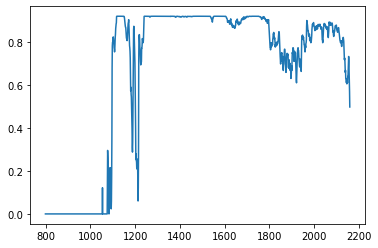

In [68]:
plt.plot(turbine.effi_cal)

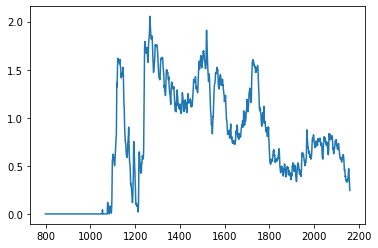

In [69]:
plt.plot(turbine.power)

In [70]:
attrs = vars(turbine)
print(', '.join("%s: %s" % item for item in attrs.items()))

tur_name: Kaplan, flow_range: [       nan        nan        nan ... 2.18676848 2.07491693 1.93191686], head: 26.52439024390244, maxflow: 8.969361158015897, h_f: [       nan        nan        nan ... 0.10933842 0.10374585 0.09659584], k1: 0.41, k2: 800, loss: 0.98, Rm: 4.5, h: 26.075922186001648, pmax: nan, pmin: 0.0017027526452872519, power: [       nan        nan        nan ... 0.34147797 0.2988894  0.24396699], effi_cal: [       nan        nan        nan ... 0.61491253 0.56711524 0.49703461], per_75: nan, raw_power: [       nan        nan        nan ... 0.34147797 0.2988894  0.24396699], G: 9.81, RHO: 1000


In [39]:
np.savetxt('power.csv', [turbine.power], delimiter=',')

# Read the raw json files

In [18]:
json_filename = 'data/2000_2020_npd/npd_09019500_2000-01-01_2020-12-31.json'

# Opening JSON file
with open(json_filename) as f:
    data = json.load(f)

In [20]:
#data = json.load(json_filename)

path='data/2000_2020_npd/npd_09019500_2000-01-01_2020-12-31.csv'
df_list = []
#print(len(data['value']['timeSeries']))
for var in data['value']['timeSeries']:
    var_name = var['variable']['variableName']
    #print(var['values'][0]['value'])
    df_temp = pd.json_normalize(var['values'][0]['value'])
    df_temp.rename(columns={"value": var_name}, inplace=True)
    df_temp['site_name'] = var['sourceInfo']['siteName']
    df_temp['site_id'] = var['sourceInfo']['siteCode'][0]['value']
    #print(var['sourceInfo']['geoLocation'])
    df_temp['lat'] = var['sourceInfo']['geoLocation']['geogLocation']['latitude']
    df_temp['long'] = var['sourceInfo']['geoLocation']['geogLocation']['longitude']
    df_list.append(df_temp)
    df_temp.to_csv(path)

In [22]:
df_list[0].head()

,"Streamflow, ft&#179;/s",qualifiers,dateTime,site_name,site_id,lat,long
0,72.0,"[A, [91]]",2000-05-02T00:00:00.000-06:00,"COLORADO RIVER NEAR GRANBY, CO",09019500,40.120819,-105.900569
1,72.0,"[A, [91]]",2000-05-02T00:30:00.000-06:00,"COLORADO RIVER NEAR GRANBY, CO",09019500,40.120819,-105.900569
2,75.0,"[A, [91]]",2000-05-02T12:00:00.000-06:00,"COLORADO RIVER NEAR GRANBY, CO",09019500,40.120819,-105.900569
3,75.0,"[A, [91]]",2000-05-03T00:00:00.000-06:00,"COLORADO RIVER NEAR GRANBY, CO",09019500,40.120819,-105.900569
4,75.0,"[A, [91]]",2000-05-03T00:30:00.000-06:00,"COLORADO RIVER NEAR GRANBY, CO",09019500,40.120819,-105.900569
